In [ ]:
'''
Created on March 24, 2020

@author: Tinglin Huang (huangtinglin@outlook.com)
'''
import easydict
args= easydict.EasyDict({"weights_path":"model/","data_path":"../Data/","proj_path":"","dataset":"gowalla","pretrain":0,"verbose":1,"epoch":400,"embed_size":64,"layer_size":"[64,64,64]","batch_size":1024,"regs":"[1e-5]","lr":0.0001,"model_type":"ngcf",
                         "adj_type":"norm","gpu_id":0,"node_dropout_flag":1,"node_dropout":"[0.1]","mess_dropout":"[0.1,0.1,0.1]","Ks":"[20, 40, 60, 80, 100]","save_flag":0,"test_flag":"part","report":0})

In [ ]:
import torch
import torch.optim as optim
from NGCF import NGCF
from utility.helper import *
from utility.batch_test import *
import warnings
warnings.filterwarnings('ignore')
from time import time


if __name__ == '__main__':
    
    GPU_NUM = 0 # 원하는 GPU 번호 입력
    args.device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
    
    print(args.device)

    plain_adj, norm_adj, mean_adj = data_generator.get_adj_mat()

    args.node_dropout = eval(args.node_dropout)
    args.mess_dropout = eval(args.mess_dropout)

    model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj,
                 args).to(args.device)
    t0 = time()
    """
    *********************************************************
    Train.
    """
    cur_best_pre_0, stopping_step = 0, 0
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    loss_loger, pre_loger, rec_loger, ndcg_loger, hit_loger = [], [], [], [], []
    for epoch in range(args.epoch):
        t1 = time()
        loss, mf_loss, emb_loss = 0., 0., 0.
        n_batch = data_generator.n_train // args.batch_size + 1

        for idx in range(n_batch):
            users, pos_items, neg_items = data_generator.sample()
            u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings = model(users,
                                                                           pos_items,
                                                                           neg_items,
                                                                           drop_flag=args.node_dropout_flag)

            batch_loss, batch_mf_loss, batch_emb_loss = model.create_bpr_loss(u_g_embeddings,
                                                                              pos_i_g_embeddings,
                                                                              neg_i_g_embeddings)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            loss += batch_loss
            mf_loss += batch_mf_loss
            emb_loss += batch_emb_loss

        if (epoch + 1) % 10 != 0:
            if args.verbose > 0 and epoch % args.verbose == 0:
                perf_str = 'Epoch %d [%.1fs]: train==[%.5f=%.5f + %.5f]' % (
                    epoch, time() - t1, loss, mf_loss, emb_loss)
                print(perf_str)
            continue

        t2 = time()
        users_to_test = list(data_generator.test_set.keys())
        ret = test(model, users_to_test, drop_flag=False)

        t3 = time()

        loss_loger.append(loss)
        rec_loger.append(ret['recall'])
        pre_loger.append(ret['precision'])
        ndcg_loger.append(ret['ndcg'])
        hit_loger.append(ret['hit_ratio'])

        if args.verbose > 0:
            perf_str = 'Epoch %d [%.1fs + %.1fs]: train==[%.5f=%.5f + %.5f], recall=[%.5f, %.5f], ' \
                       'precision=[%.5f, %.5f], hit=[%.5f, %.5f], ndcg=[%.5f, %.5f]' % \
                       (epoch, t2 - t1, t3 - t2, loss, mf_loss, emb_loss, ret['recall'][0], ret['recall'][-1],
                        ret['precision'][0], ret['precision'][-1], ret['hit_ratio'][0], ret['hit_ratio'][-1],
                        ret['ndcg'][0], ret['ndcg'][-1])
            print(perf_str)

        cur_best_pre_0, stopping_step, should_stop = early_stopping(ret['recall'][0], cur_best_pre_0,
                                                                    stopping_step, expected_order='acc', flag_step=5)

        # *********************************************************
        # early stopping when cur_best_pre_0 is decreasing for ten successive steps.
        if should_stop == True:
            break

        # *********************************************************
        # save the user & item embeddings for pretraining.
        if ret['recall'][0] == cur_best_pre_0 and args.save_flag == 1:
            torch.save(model.state_dict(), args.weights_path + str(epoch) + '.pkl')
            print('save the weights in path: ', args.weights_path + str(epoch) + '.pkl')

    recs = np.array(rec_loger)
    pres = np.array(pre_loger)
    ndcgs = np.array(ndcg_loger)
    hit = np.array(hit_loger)

    best_rec_0 = max(recs[:, 0])
    idx = list(recs[:, 0]).index(best_rec_0)

    final_perf = "Best Iter=[%d]@[%.1f]\trecall=[%s], precision=[%s], hit=[%s], ndcg=[%s]" % \
                 (idx, time() - t0, '\t'.join(['%.5f' % r for r in recs[idx]]),
                  '\t'.join(['%.5f' % r for r in pres[idx]]),
                  '\t'.join(['%.5f' % r for r in hit[idx]]),
                  '\t'.join(['%.5f' % r for r in ndcgs[idx]]))
    print(final_perf)

In [20]:
import pandas as pd
import numpy as np

train = pd.read_csv('C://Users//Kss//.conda//envs//torch//NGCF//dataset//train.csv')

In [ ]:
text = pd.read_txt('C://Users//Kss//.conda//envs//torch//NGCF//dataset//train.csv')

In [ ]:
train

In [ ]:
userlist = np.zeros(user.shape)
userlist[:,0] = user['user']
userlist[:,1] = user['list']

In [ ]:
for i in range (len(network)):
    for j in range (len(userlist)):
        if network[i,0] == userlist[j,0]:
            network[i,0] = userlist[j,1]

In [ ]:
file = open('hello.txt', 'w')  
file.write('Hello, world!') 
file.close()  

In [ ]:
for i in range (len(gamelist)):
    for j in range (len(game)):
        if gamelist[i] == game['Game'][j]:
            network[i,1] = game['list'][j]

In [ ]:
f = open("새파일.txt", 'w')
for i in range (len(train)):
    column = train.loc[i].dropna(axis=0)
    for j in range(len(column)):
        if j < len(column)-1:
            data = str(int(column[j])) + " "
        else:
            data =  str(int(column[j]))
        f.write(data)
    f.write("\n")

f.close()

In [21]:
train

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,0,0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,26,27.0,0.0,28.0,29.0,30.0,31.0,32.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,46,47.0,4.0,48.0,49.0,50.0,51.0,52.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11345,11345,341,9.0,535.0,4.0,456.0,543.0,843.0,840.0,876.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11346,11346,21,485.0,52.0,46.0,76.0,411.0,0.0,671.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11347,11347,21,39.0,280.0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11348,11348,21,9.0,276.0,494.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import pandas as pd
import numpy as np

train = pd.read_csv('C://Users//Kss//.conda//envs//torch//NGCF//train.csv')

In [28]:
from sklearn import datasets
import pandas as pd
iris = train

labels = pd.DataFrame(iris['label'])

data = iris

data.head()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,label
0,0.132903,-0.307991,-0.333583,-0.292692,0.113312,0.328450,-0.319215,0.289061,0.155505,-0.222253,...,-0.000861,-0.008322,0.268838,0.151419,-0.050948,0.077602,-0.001188,0.007488,-0.000395,0
1,0.220371,-0.385825,-0.367398,-0.350414,0.209629,0.438514,-0.168493,0.106955,0.425768,0.368815,...,-0.005419,0.000000,-0.138164,0.171400,-0.138046,0.056611,-0.174239,-0.002460,0.000000,0
2,0.133463,-0.329951,-0.295019,-0.361737,0.219864,-0.321650,-0.234132,0.281220,0.217451,-0.319287,...,0.182546,-0.043383,0.012290,0.087448,-0.111444,0.341132,0.000000,0.103789,-0.019328,0
3,0.274893,0.130080,0.036310,-0.339468,0.400107,0.510919,-0.295419,0.324113,0.031127,0.289062,...,-0.202894,-0.114502,-0.155322,-0.044735,-0.037548,0.247054,0.000000,-0.147756,-0.037286,0
4,0.046382,-0.136582,-0.260131,-0.283002,0.122099,0.168507,-0.250971,0.044187,-0.003110,-0.201914,...,0.075003,-0.003035,0.208109,0.206096,-0.074194,0.027500,-0.013559,0.051230,0.023142,0


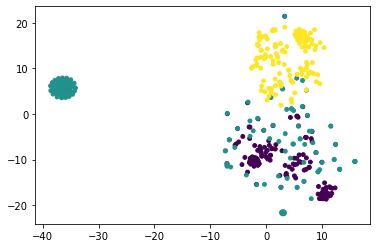

In [70]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(init='random', learning_rate=50)

transformed = model.fit_transform(train)

xs = transformed[:,0]
ys = transformed[:,1]

    
plt.scatter(xs,ys,s =15,c=labels['label'])

plt.show()

In [29]:
for i, target in enumerate(labels):
    plt.text(xs[i],ys[i],target[i])

,label
0,0
1,0
2,0
3,0
4,0
...,...
379,2
380,2
381,2
382,2


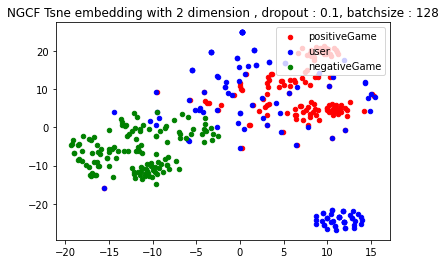

In [132]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(init='random', learning_rate=3)

transformed = model.fit_transform(train)

xs = transformed[:,0]
ys = transformed[:,1]

plt.title('NGCF Tsne embedding with 2 dimension , dropout : 0.1, batchsize : 128')
plt.scatter(xs[0:128],ys[0:128],s =20,c= 'r',label = 'positiveGame')
plt.scatter(xs[128:256],ys[128:256],s =20,c= 'b',label = 'user')
plt.scatter(xs[256:],ys[256:],s =20,c='g',label = 'negativeGame')
plt.rcParams["figure.figsize"] = (6,4)

plt.legend(loc='upper right')
plt.show()

In [77]:
train2 = pd.read_csv('C://Users//Kss//.conda//envs//torch//NGCF//train2.csv')

In [81]:
iris2 = train2

labels2 = pd.DataFrame(iris2['label'])

data = iris2

data.head()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,label
0,0.072662,0.166846,0.191335,0.187538,-0.175099,-0.127061,-0.136899,0.161533,0.237058,-0.182963,...,0.000000,0.000000,0.348683,0.000000,-0.024207,0.363655,0.074124,-0.023850,-0.011342,0
1,0.225809,0.143937,0.246760,-0.164027,-0.040179,0.041222,-0.150600,-0.020704,0.228496,-0.305534,...,0.000000,0.000000,0.272849,-0.043428,0.000000,0.000000,0.289227,-0.069433,0.000000,0
2,0.109571,0.141979,0.155339,0.174894,-0.180450,-0.095599,-0.109464,0.159104,0.206718,-0.130120,...,-0.000706,-0.085676,0.000000,0.000000,0.000000,0.466805,0.000000,-0.030615,0.000000,0
3,0.323611,0.338266,0.114061,0.168887,-0.325781,-0.135528,-0.183158,0.161506,0.151494,-0.132167,...,0.000000,0.000000,-0.012963,0.081579,0.039623,0.153457,0.000000,0.000000,0.002279,0
4,0.181655,0.026160,0.077482,-0.059077,-0.077401,-0.019135,0.129993,-0.192312,0.202123,0.015318,...,-0.035032,0.048887,-0.021994,0.337988,0.000000,0.000000,-0.117526,0.000000,0.441632,0


c:\Users\Kss\.conda\envs\torch\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


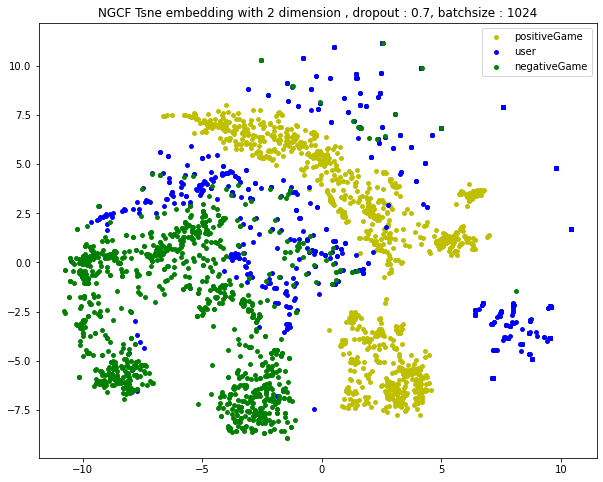

In [120]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(init='pca', learning_rate=0.4)

transformed = model.fit_transform(train2)

xs = transformed[:,0]
ys = transformed[:,1]
plt.title('NGCF Tsne embedding with 2 dimension , dropout : 0.7, batchsize : 1024')
plt.scatter(xs[0:1024],ys[0:1024],s =15,c= 'y', label = 'positiveGame')
plt.scatter(xs[1024:2048],ys[1024:2048],s =15,c= 'b', label = 'user')
plt.scatter(xs[2048:],ys[2048:],s =15,c='g',label = 'negativeGame')
plt.rcParams["figure.figsize"] = (14,10)

plt.legend(loc='upper right')

plt.show()

In [91]:
loss = pd.read_csv('C://Users//Kss//.conda//envs//torch//NGCF//minlossper10epoch.csv')

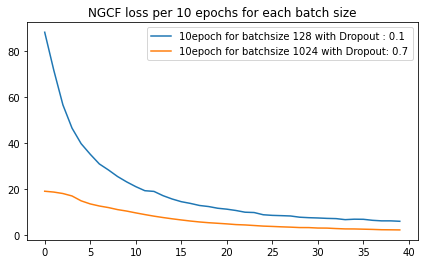

In [128]:
plt.title('NGCF loss per 10 epochs for each batch size')
plt.plot(loss['10epoch for batchsize 128'],label = '10epoch for batchsize 128 with Dropout : 0.1')
plt.plot(loss['10epoch for batchsize 1024'],label = '10epoch for batchsize 1024 with Dropout: 0.7')
plt.rcParams["figure.figsize"] = (8,4)
plt.legend()
plt.show()

,10epoch for batchsize 1024,10epoch for batchsize 128
0,18.9169,88.0090
1,18.5502,71.4668
2,17.9195,56.4330
3,16.8584,46.3470
4,14.7434,39.5890
5,13.4057,34.9909
6,12.4990,30.7743
7,11.8151,28.1626
8,10.9363,25.3156
9,10.2949,22.9796
